# Set up

By clustering the customers and then doing customer profiling, we can find the demographics of the cluster (eg. parents with kids, couples without children), the products they are more likely to buy, their media habits (website or store), and how well recieved each promotional campaign is to each group. This way, the shop can design more specific marketing campaigns for customers of different demographics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv("marketing_campaign.csv")

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04/09/12,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08/03/14,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21/08/13,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10/02/14,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19/01/14,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
len(df)

2240

In [6]:
df = df.dropna()
print("The total number of datapoints after removing the rows with missing values are:", len(df))

The total number of datapoints after removing the rows with missing values are: 2216


# Feature Engineering

In [7]:
data = df.copy()

## Create new features

In [8]:
# Create a feature of num of days a customer is registered relative to the most recent customer in the record
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i) 
    
days = []
d1 = max(dates) # relative to the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")
data["Customer_For"]

0       83894400000000000
1       10800000000000000
2       40780800000000000
3        5616000000000000
4       27734400000000000
              ...        
2235    46742400000000000
2236     5270400000000000
2237    27216000000000000
2238    27302400000000000
2239    67564800000000000
Name: Customer_For, Length: 2216, dtype: int64

In [9]:
# Create feature age (relative to year 2024)
data["Age"] = 2024-data["Year_Birth"]

In [10]:
# Create feature of total amt spent over all categories over the 2 years
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"] + data["MntSweetProducts"]+ data["MntGoldProds"]

In [11]:
# Create living situation feature from marital status
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", 
                                                    "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

# Create feature of total children living in the household
data["Children"] = data["Kidhome"]+data["Teenhome"]

# Create feature of total members in the household
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

# Create feature of parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

In [12]:
# Categorise educational levels into 3 general ones
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", 
                                             "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

In [13]:
# Drop redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

## Pre-process data

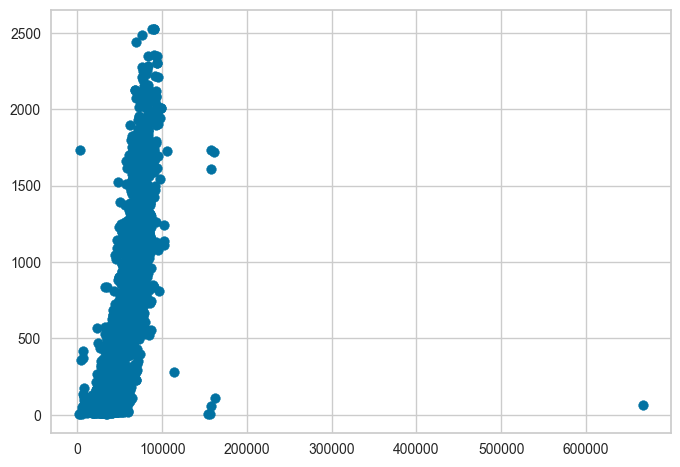

In [14]:
plt.scatter(data["Income"], data["Spent"])
plt.show()

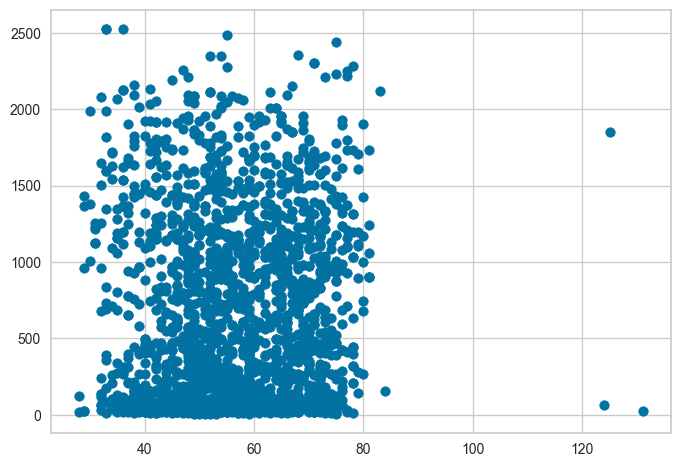

In [15]:
plt.scatter(data["Age"], data["Spent"])
plt.show()

In [16]:
# Drop outliers for age & income
data = data[(data["Age"]<100)] # check if need modify the num
data = data[(data["Income"]<600000)]
print("The total number of datapoints after removing the outliers are:", len(data))

The total number of datapoints after removing the outliers are: 2212


In [17]:
# Encode categorical features
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables in the dataset:", object_cols)

LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
data.head()

Categorical variables in the dataset: ['Education', 'Living_With']


,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,83894400000000000,67,1617,0,0,1,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,10800000000000000,70,27,0,2,3,1
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,40780800000000000,59,776,1,0,2,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,5616000000000000,40,53,1,1,3,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,27734400000000000,43,422,1,1,3,1


In [18]:
data.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Customer_For', 'Age', 'Spent',
       'Living_With', 'Children', 'Family_Size', 'Is_Parent'],
      dtype='object')

**Variable Selection for Customer Segmentation**

We have chosen to remove the following set of columns which are not so relevant in understanding who the customers are and thier purchasing habits
- AcceptedCmp3
- AcceptedCmp4
- AcceptedCmp5
- AcceptedCmp1
- AcceptedCmp2
- Complain
- Response

In [19]:
data_selected = data.copy()
cols_to_drop = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
data_selected = data_selected.drop(cols_to_drop, axis=1)

In [20]:
# Scale features
scaler = StandardScaler()
scaler.fit(data_selected)
scaled_ds = pd.DataFrame(scaler.transform(data_selected), columns= data_selected.columns)

# PCA: Dimensionality Reducation

3 is chosen so that not too small (so less missing impt info cpatured) & can still visualise the clusters using 3D

In [21]:
# PCA with 3 components on scaled dataset
pca = PCA(n_components=3)
pca.fit(scaled_ds)

PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=["col1", "col2", "col3"])

PCA_summary = PCA_ds.describe().T
PCA_summary

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-3.854662e-17,2.878377,-5.969395,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,6.424437e-18,1.706839,-4.312291,-1.328302,-0.158143,1.242293,6.142786
col3,2212.0,7.227492e-18,1.221953,-3.530752,-0.828703,-0.020364,0.799997,6.622715


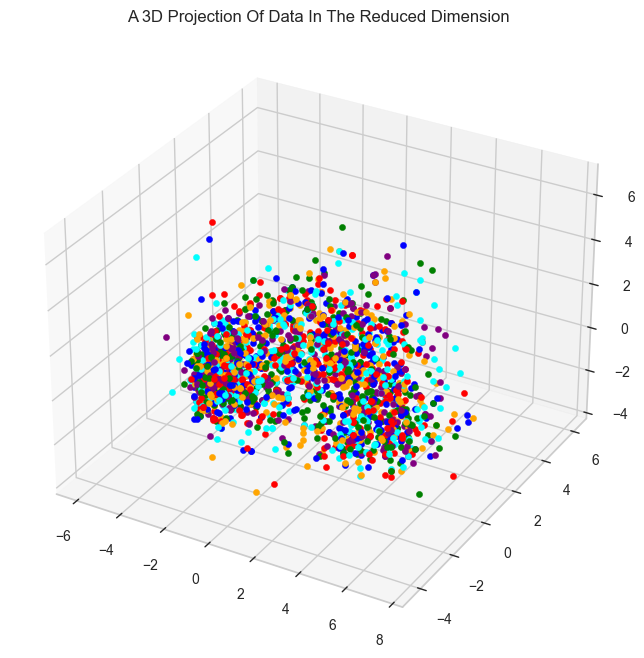

In [22]:
# Visualise
x = PCA_ds["col1"]
y = PCA_ds["col2"]
z = PCA_ds["col3"]
colors = ["red", "green", "blue", "orange", "purple", "cyan"]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
for i in range(len(x)):
    ax.scatter(x[i], y[i], z[i], c=colors[i % len(colors)], marker="o")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Clustering: Agglomerative

Elbow Method to determine the number of clusters to be formed:


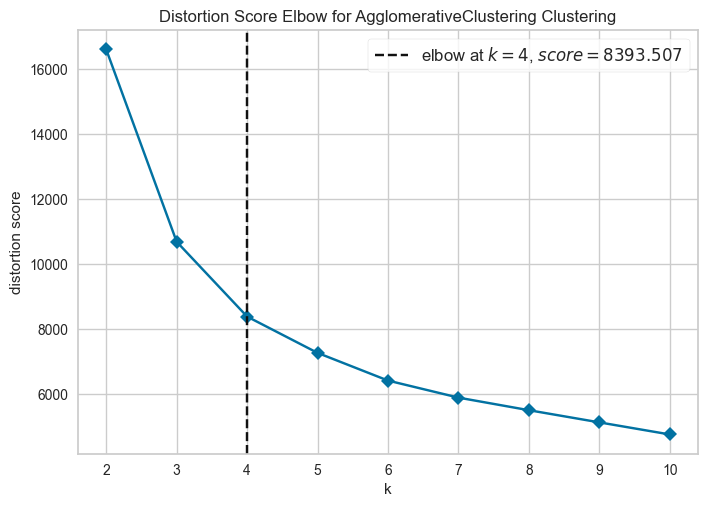

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# determine num of clusters to be formed
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(
    AgglomerativeClustering(),
    k=10,
    locate_elbow=True,
    timings=False
)

Elbow_M.fit(PCA_ds)
Elbow_M.show()

## Build clusters

Diff linkages available:
- 'ward': Min the variance of the clusters being merged (only works with  Euclidean distance)
- 'complete': Merges clusters based on the max distance between points in the 2 clusters
- 'average': Uses the average of the distances between all pairs of points in the 2 clusters
- 'single': Merges clusters based on the min distance between points in the 2 clusters

Diff distance metric (affinity): (not for 'ward')
- 'euclidean' (l2), 'manhattan' (l1), 'cosine', 'chebyshev', 'minkowski'

In [24]:
# Perform clustering with ward linkage
C_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
yhat_ward = C_ward.fit_predict(PCA_ds)

In [25]:
# store
PCA_ds_clusters = PCA_ds.copy()
PCA_ds_clusters["Cluster ward"] = yhat_ward

og_data_clusters = data.copy()
og_data_clusters["Cluster ward"] = yhat_ward

**Evalution methods:**
- **Silhouette Score**: Measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Score ranges from -1 to 1: *higher* score indicates that object is *well clustered*.
- **Davies-Bouldin Index**: Measures the avg similarity ratio of each cluster with the one most similar to it; looks at the ratio of within-cluster distances to between-cluster distances. A *lower* value indicates better clustering
- **Calinski-Harabasz Index** (Variance Ratio Criterion): Ratio of the sum of between-cluster dispersion to within-cluster dispersion. A *higher* score indicates better-defined clusters

In [28]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette_avg_ward = silhouette_score(PCA_ds, yhat_ward)
db_index_ward = davies_bouldin_score(PCA_ds, yhat_ward)
ch_index_ward = calinski_harabasz_score(PCA_ds, yhat_ward)

print("Evaluation scores for ward linkage")
print(f"Silhouette Score: {silhouette_avg_ward}")
print(f"Davies-Bouldin Index: {db_index_ward}")
print(f"Calinski-Harabasz Index: {ch_index_ward}")

Evaluation scores for ward linkage
Silhouette Score: 0.341202942544232
Davies-Bouldin Index: 0.9971190650228596
Calinski-Harabasz Index: 1724.5760683724923


In [29]:
# Other linkages and distance metrics
linkages = ['complete', 'average', 'single']
dist_metrics = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']
results = {}

for linkage in linkages:
    for dist in dist_metrics: 
        clustering = AgglomerativeClustering(n_clusters=4, metric=dist, linkage=linkage)
        labels = clustering.fit_predict(PCA_ds)

        # Store
        PCA_ds_clusters[f"Cluster {linkage} {dist}"] = labels
        og_data_clusters[f"Cluster {linkage} {dist}"] = labels
        
        # Evaluation scores
        silhouette_avg = silhouette_score(PCA_ds, labels)
        db_index = davies_bouldin_score(PCA_ds, labels)
        ch_index = calinski_harabasz_score(PCA_ds, labels)
        
        # Store results
        results[(linkage, dist)] = {
            "Silhouette Score": silhouette_avg,
            "Davies-Bouldin Index": db_index,
            "Calinski-Harabasz Index": ch_index
        }

for pair, metrics in results.items():
    print(f"\nLinkage, Distance Metric: {pair}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Linkage, Distance Metric: ('complete', 'euclidean')
Silhouette Score: 0.2539
Davies-Bouldin Index: 1.4158
Calinski-Harabasz Index: 1308.8892

Linkage, Distance Metric: ('complete', 'manhattan')
Silhouette Score: 0.2061
Davies-Bouldin Index: 1.5411
Calinski-Harabasz Index: 861.5019

Linkage, Distance Metric: ('complete', 'cosine')
Silhouette Score: 0.2497
Davies-Bouldin Index: 1.2813
Calinski-Harabasz Index: 1112.4999

Linkage, Distance Metric: ('complete', 'chebyshev')
Silhouette Score: 0.3243
Davies-Bouldin Index: 0.8955
Calinski-Harabasz Index: 1099.7992

Linkage, Distance Metric: ('complete', 'minkowski')
Silhouette Score: 0.2539
Davies-Bouldin Index: 1.4158
Calinski-Harabasz Index: 1308.8892

Linkage, Distance Metric: ('average', 'euclidean')
Silhouette Score: 0.2767
Davies-Bouldin Index: 0.7280
Calinski-Harabasz Index: 535.4621

Linkage, Distance Metric: ('average', 'manhattan')
Silhouette Score: 0.2814
Davies-Bouldin Index: 0.7110
Calinski-Harabasz Index: 546.7057

Linkage, Dist

In [30]:
PCA_ds_clusters.head()

,col1,col2,col3,Cluster ward,Cluster complete euclidean,Cluster complete manhattan,Cluster complete cosine,Cluster complete chebyshev,Cluster complete minkowski,Cluster average euclidean,Cluster average manhattan,Cluster average cosine,Cluster average chebyshev,Cluster average minkowski,Cluster single euclidean,Cluster single manhattan,Cluster single cosine,Cluster single chebyshev,Cluster single minkowski
0,4.994347,-0.151161,2.644289,1,3,3,0,0,3,2,2,0,1,2,0,1,0,0,0
1,-2.884455,-0.006657,-1.864387,3,2,1,2,1,2,0,0,1,2,0,0,1,0,0,0
2,2.617864,-0.720754,-0.253540,1,3,0,0,0,3,2,2,0,1,2,0,1,0,0,0
3,-2.676036,-1.541978,-0.923122,0,2,3,1,1,2,0,0,1,2,0,0,1,0,0,0
4,-0.649591,0.209773,-0.018477,2,2,1,2,1,2,0,0,1,2,0,0,1,0,0,0


In [31]:
og_data_clusters.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Cluster average euclidean,Cluster average manhattan,Cluster average cosine,Cluster average chebyshev,Cluster average minkowski,Cluster single euclidean,Cluster single manhattan,Cluster single cosine,Cluster single chebyshev,Cluster single minkowski
0,0,58138.0,0,0,58,635,88,546,172,88,...,2,2,0,1,2,0,1,0,0,0
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,1,2,0,0,1,0,0,0
2,0,71613.0,0,0,26,426,49,127,111,21,...,2,2,0,1,2,0,1,0,0,0
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,1,2,0,0,1,0,0,0
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,1,2,0,0,1,0,0,0


## Plots to visualise clusters

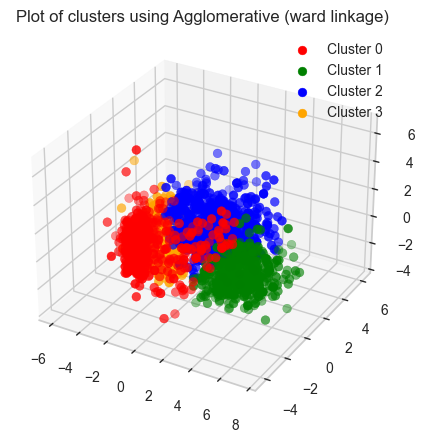

In [32]:
# Plot to visualise clusters using PCA components
colors = ["red", "green", "blue", "orange"] # for each cluster

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d', label="bla")

for cluster_id in range(len(colors)):
    cluster_data = PCA_ds_clusters[PCA_ds_clusters["Cluster ward"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        cluster_data["col3"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

ax.set_title("Plot of clusters using Agglomerative (ward linkage)")
ax.legend()
plt.show()

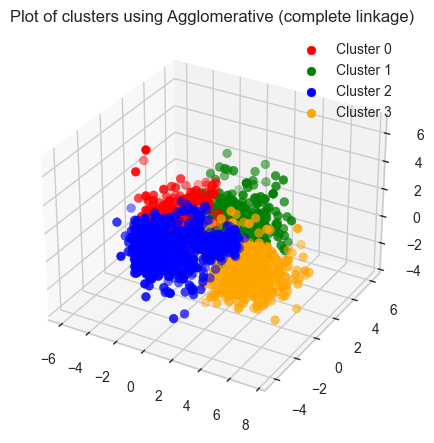

In [33]:
# Plot to visualise clusters using PCA components
colors = ["red", "green", "blue", "orange"] # for each cluster

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d', label="bla")

for cluster_id in range(len(colors)):
    cluster_data = PCA_ds_clusters[PCA_ds_clusters["Cluster complete euclidean"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        cluster_data["col3"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

ax.set_title("Plot of clusters using Agglomerative (complete linkage)")
ax.legend()
plt.show()

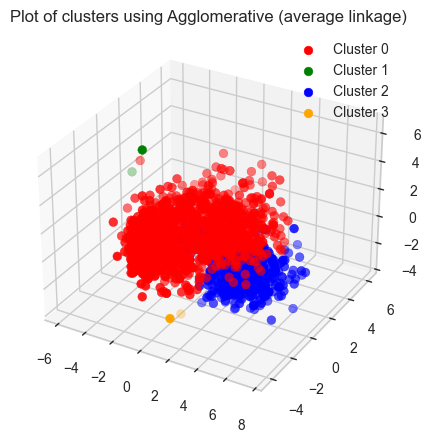

In [35]:
# Plot to visualise clusters using PCA components
colors = ["red", "green", "blue", "orange"] # for each cluster

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d', label="bla")

for cluster_id in range(len(colors)):
    cluster_data = PCA_ds_clusters[PCA_ds_clusters["Cluster average euclidean"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        cluster_data["col3"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

ax.set_title("Plot of clusters using Agglomerative (average linkage)")
ax.legend()
plt.show()

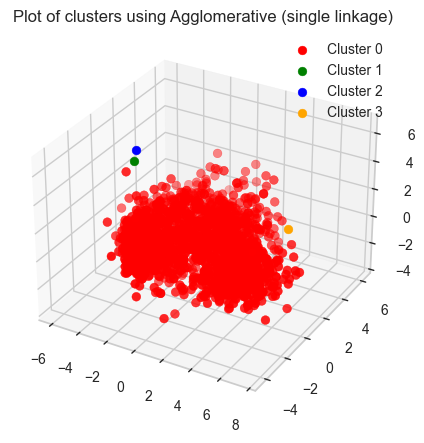

In [36]:
# Plot to visualise clusters using PCA components
colors = ["red", "green", "blue", "orange"] # for each cluster

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d', label="bla")

for cluster_id in range(len(colors)):
    cluster_data = PCA_ds_clusters[PCA_ds_clusters["Cluster single euclidean"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        cluster_data["col3"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

ax.set_title("Plot of clusters using Agglomerative (single linkage)")
ax.legend()
plt.show()

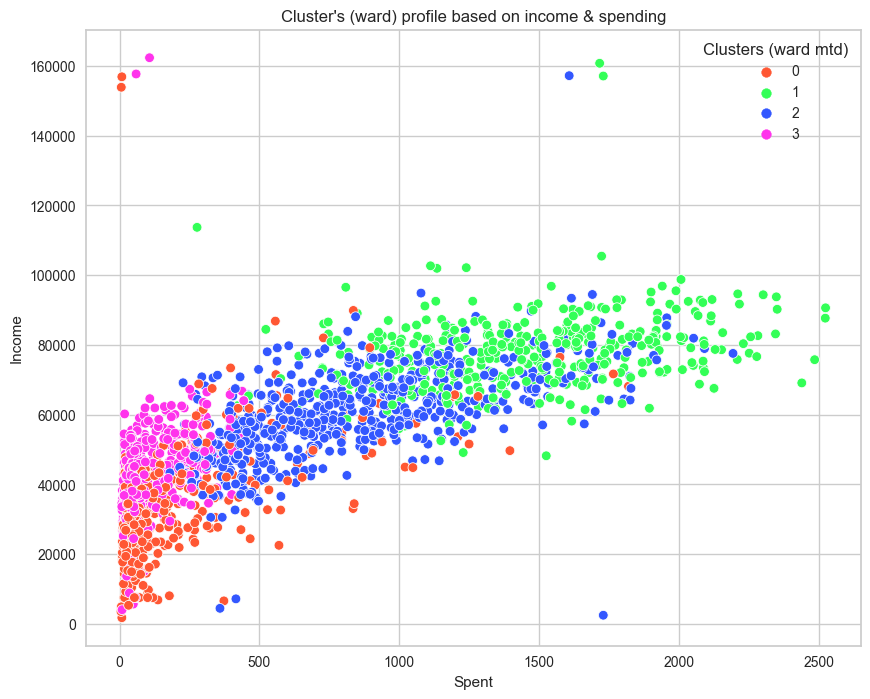

In [37]:
import seaborn as sns

# Visualise spending and income based on the clusters
palette = ["#FF5733", "#33FF57", "#3357FF", "#FF33EC"]
plt.figure(figsize=(10, 8))

scatterplot = sns.scatterplot(data=og_data_clusters, x="Spent", y="Income", hue="Cluster ward", palette=palette)
scatterplot.set_title("Cluster's (ward) profile based on income & spending")
plt.legend(title="Clusters (ward mtd)")
plt.show()

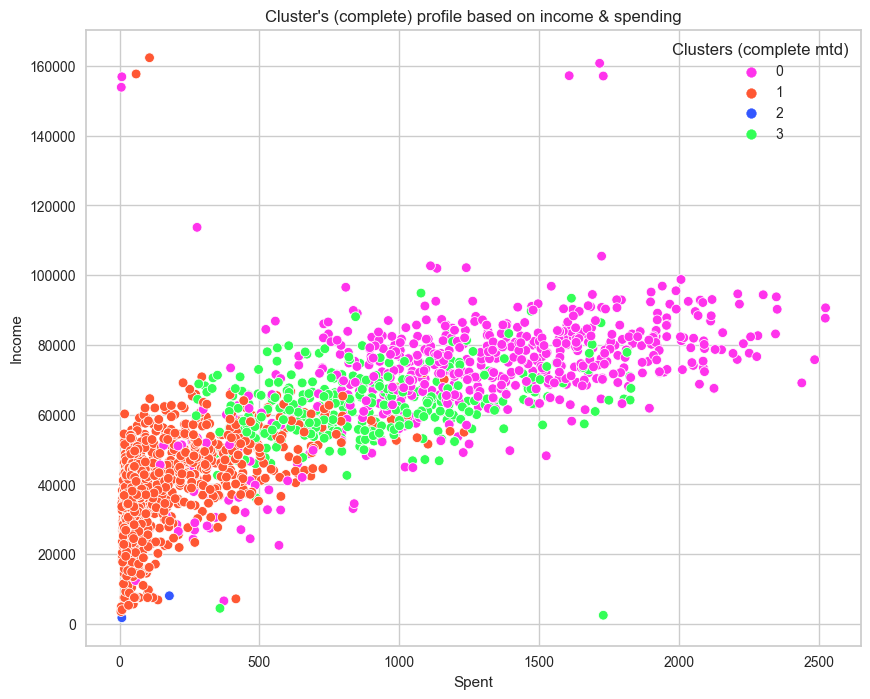

In [51]:
palette = ["#FF33EC", "#FF5733", "#3357FF", "#33FF57"]
plt.figure(figsize=(10, 8))
scatterplot = sns.scatterplot(data=og_data_clusters, x="Spent", y="Income", hue="Cluster complete chebyshev", palette=palette)
scatterplot.set_title("Cluster's (complete) profile based on income & spending")
plt.legend(title="Clusters (complete mtd)")
plt.show()

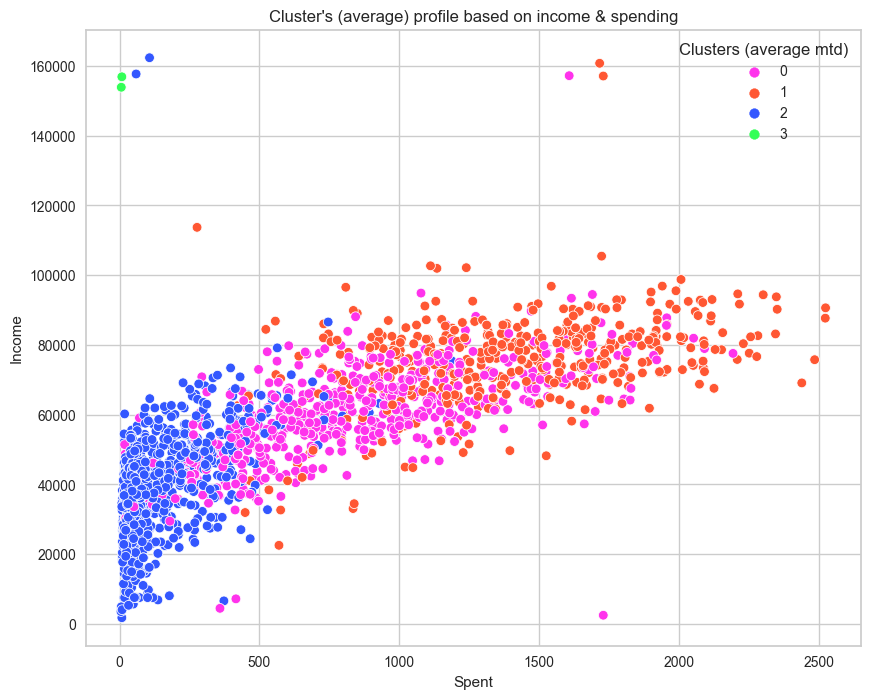

In [52]:
palette = ["#FF33EC", "#FF5733", "#3357FF", "#33FF57"]
plt.figure(figsize=(10, 8))

scatterplot = sns.scatterplot(data=og_data_clusters, x="Spent", y="Income", hue="Cluster average chebyshev", palette=palette)
scatterplot.set_title("Cluster's (average) profile based on income & spending")
plt.legend(title="Clusters (average mtd)")
plt.show()

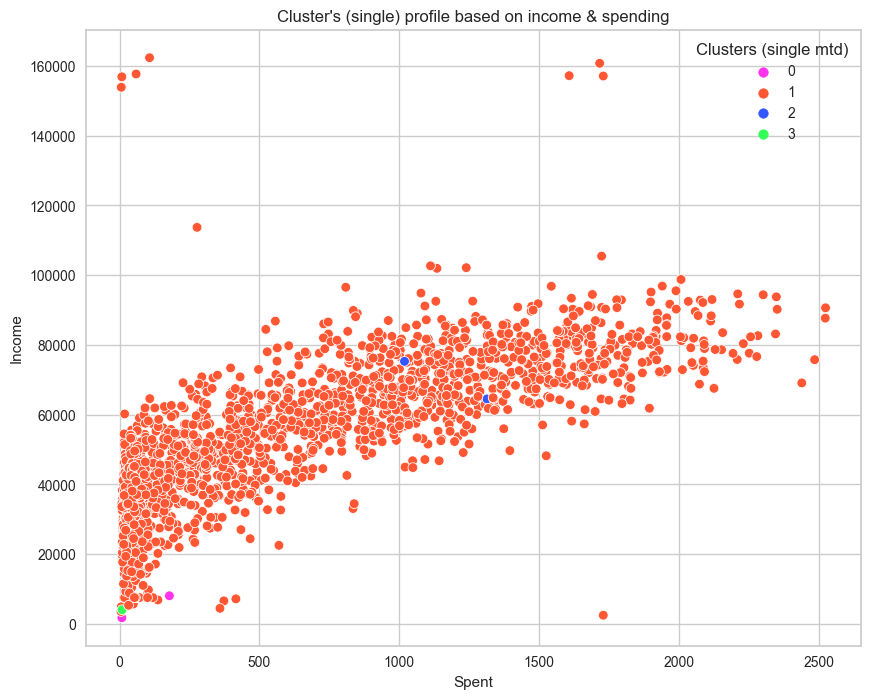

In [53]:
palette = ["#FF33EC", "#FF5733", "#3357FF", "#33FF57"]
plt.figure(figsize=(10, 8))

scatterplot = sns.scatterplot(data=og_data_clusters, x="Spent", y="Income", hue="Cluster single manhattan", palette=palette)
scatterplot.set_title("Cluster's (single) profile based on income & spending")
plt.legend(title="Clusters (single mtd)")
plt.show()

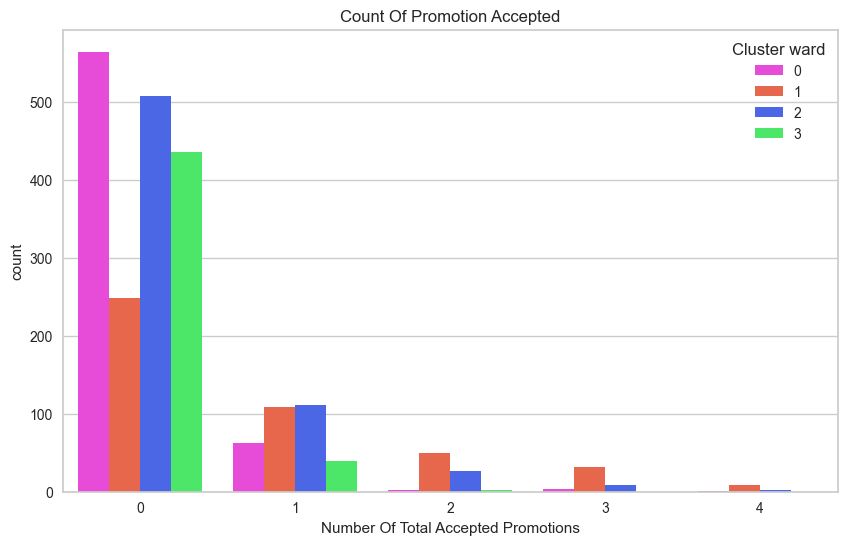

In [39]:
# Creating a feature to get the sum of accepted promotions
og_data_clusters["Total_Promos"] = og_data_clusters["AcceptedCmp1"] + og_data_clusters["AcceptedCmp2"] + og_data_clusters["AcceptedCmp3"] + og_data_clusters["AcceptedCmp4"] + og_data_clusters["AcceptedCmp5"]

plt.figure(figsize=(10, 6))
countplot = sns.countplot(x=og_data_clusters["Total_Promos"], hue=og_data_clusters["Cluster ward"], palette=palette)
countplot.set_title("Count Of Promotion Accepted")
countplot.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

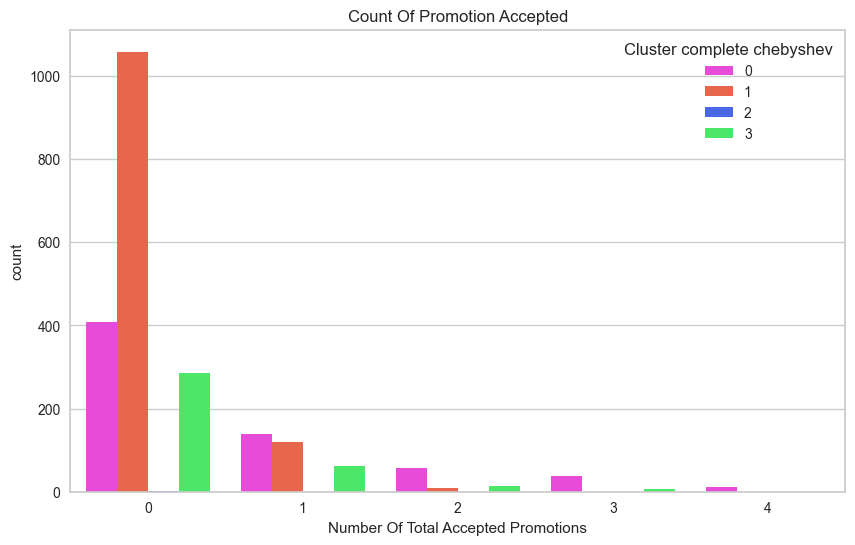

In [54]:
# Creating a feature to get the sum of accepted promotions
og_data_clusters["Total_Promos"] = og_data_clusters["AcceptedCmp1"] + og_data_clusters["AcceptedCmp2"] + og_data_clusters["AcceptedCmp3"] + og_data_clusters["AcceptedCmp4"] + og_data_clusters["AcceptedCmp5"]

plt.figure(figsize=(10, 6))
countplot = sns.countplot(x=og_data_clusters["Total_Promos"], hue=og_data_clusters["Cluster complete chebyshev"], palette=palette)
countplot.set_title("Count Of Promotion Accepted")
countplot.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

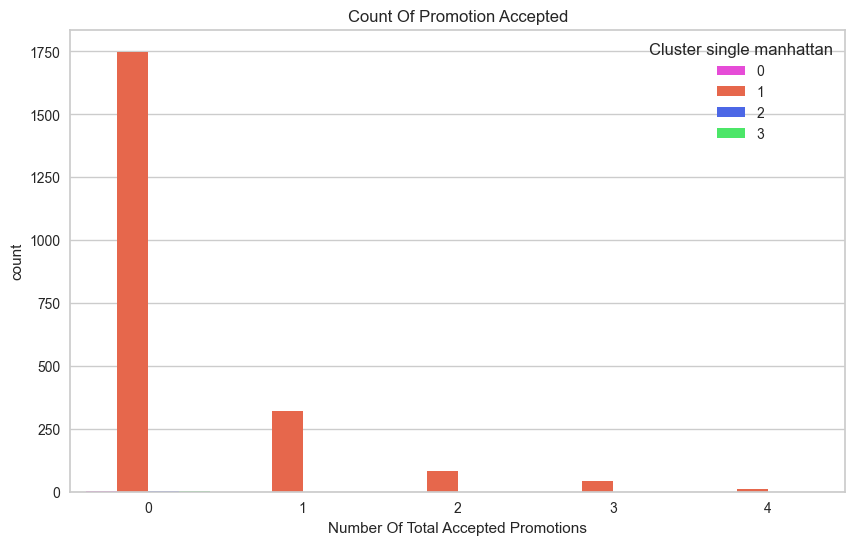

In [57]:
# Creating a feature to get the sum of accepted promotions
og_data_clusters["Total_Promos"] = og_data_clusters["AcceptedCmp1"] + og_data_clusters["AcceptedCmp2"] + og_data_clusters["AcceptedCmp3"] + og_data_clusters["AcceptedCmp4"] + og_data_clusters["AcceptedCmp5"]

plt.figure(figsize=(10, 6))
countplot = sns.countplot(x=og_data_clusters["Total_Promos"], hue=og_data_clusters["Cluster single manhattan"], palette=palette)
countplot.set_title("Count Of Promotion Accepted")
countplot.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

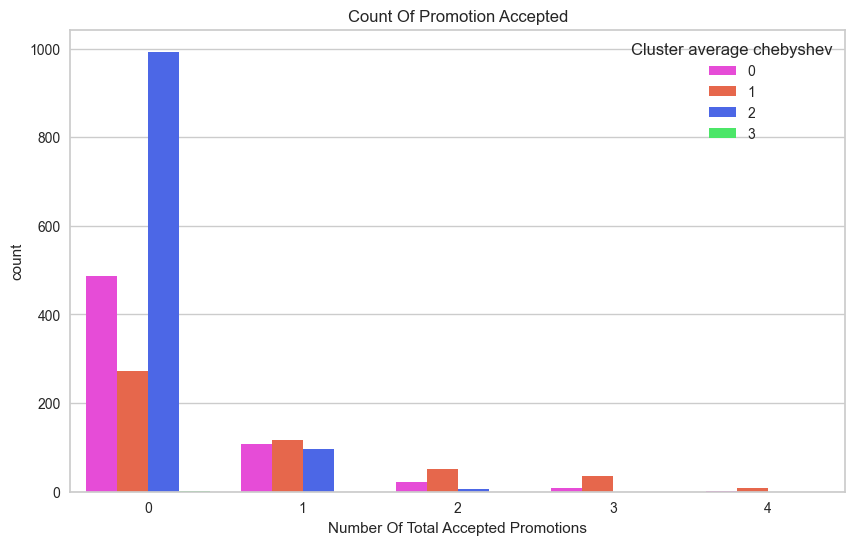

In [55]:
# Creating a feature to get the sum of accepted promotions
og_data_clusters["Total_Promos"] = og_data_clusters["AcceptedCmp1"] + og_data_clusters["AcceptedCmp2"] + og_data_clusters["AcceptedCmp3"] + og_data_clusters["AcceptedCmp4"] + og_data_clusters["AcceptedCmp5"]

plt.figure(figsize=(10, 6))
countplot = sns.countplot(x=og_data_clusters["Total_Promos"], hue=og_data_clusters["Cluster average chebyshev"], palette=palette)
countplot.set_title("Count Of Promotion Accepted")
countplot.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

# Clustering: Divisive

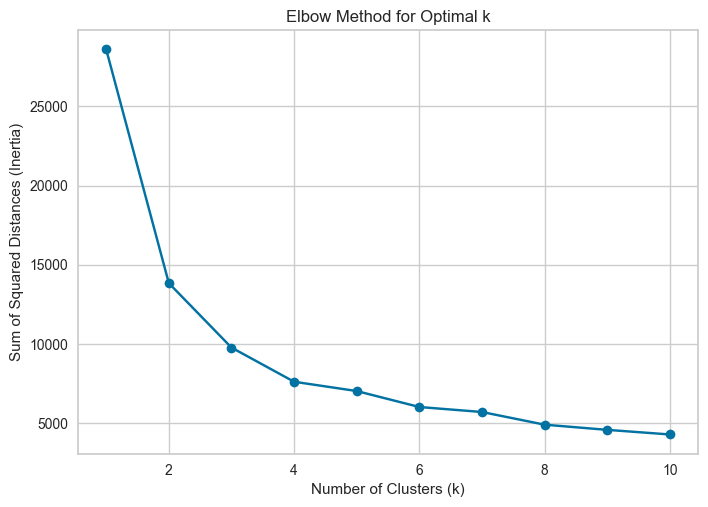

In [75]:
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(PCA_ds_div)
    sse.append(kmeans.inertia_)  

plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.show()

In [59]:
from sklearn.cluster import KMeans
def divisive_clustering(data, n_clusters):
    clusters = {0: data}  # Start with all data in one cluster
    cluster_labels = np.zeros(len(data))  # Label for each data point
    current_cluster_id = 1  # Used to label newly created clusters

    # Split clusters iteratively until we reach the desired number of clusters
    while len(clusters) < n_clusters:
        # Find the largest cluster to split
        largest_cluster_id = max(clusters, key=lambda k: len(clusters[k]))
        largest_cluster = clusters.pop(largest_cluster_id)  # Remove the cluster

        # Perform KMeans with k=2 on the largest cluster
        kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42).fit(largest_cluster)
        labels = kmeans.labels_

        # Split the cluster into two based on KMeans labels
        cluster_1 = largest_cluster[labels == 0]
        cluster_2 = largest_cluster[labels == 1]

        # Add the new clusters to the cluster dictionary
        clusters[current_cluster_id] = cluster_1
        clusters[current_cluster_id + 1] = cluster_2

        # Update the labels of the original dataset
        cluster_labels[np.isin(data, cluster_1).all(axis=1)] = current_cluster_id
        cluster_labels[np.isin(data, cluster_2).all(axis=1)] = current_cluster_id + 1

        current_cluster_id += 2

    return cluster_labels

n_clusters = 4
PCA_ds_div = PCA_ds.copy()
yhat_div = divisive_clustering(PCA_ds_div, n_clusters)

In [60]:
PCA_ds_div['Cluster'] = yhat_div    # cluster nums are {3,4,5,6}
mapping = {3: 0, 4: 1, 5: 2, 6: 3}
PCA_ds_div['Cluster'] = PCA_ds_div['Cluster'].map(mapping)

In [61]:
og_data_div = data.copy()
og_data_div["Cluster"] = yhat_div
og_data_div['Cluster'] = og_data_div['Cluster'].map(mapping)

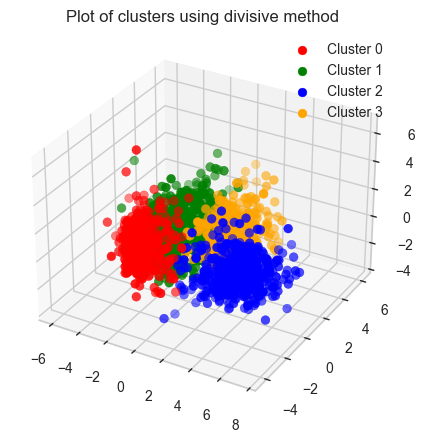

In [62]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d', label="bla")

for cluster_id in range(len(colors)):
    cluster_data = PCA_ds_div[PCA_ds_div["Cluster"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        cluster_data["col3"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

ax.set_title("Plot of clusters using divisive method")
ax.legend()
plt.show()

In [63]:
# Evaluation
silhouette_div = silhouette_score(PCA_ds, PCA_ds_div['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.4f}")
    
db_index_div = davies_bouldin_score(PCA_ds, PCA_ds_div['Cluster'])
print(f"Davies-Bouldin Index: {db_index_div:.4f}")
    
ch_index_div = calinski_harabasz_score(PCA_ds, PCA_ds_div['Cluster'])
print(f"Calinski-Harabasz Index: {ch_index_div:.4f}")

Silhouette Score: 0.1370
Davies-Bouldin Index: 1.0564
Calinski-Harabasz Index: 1831.5529


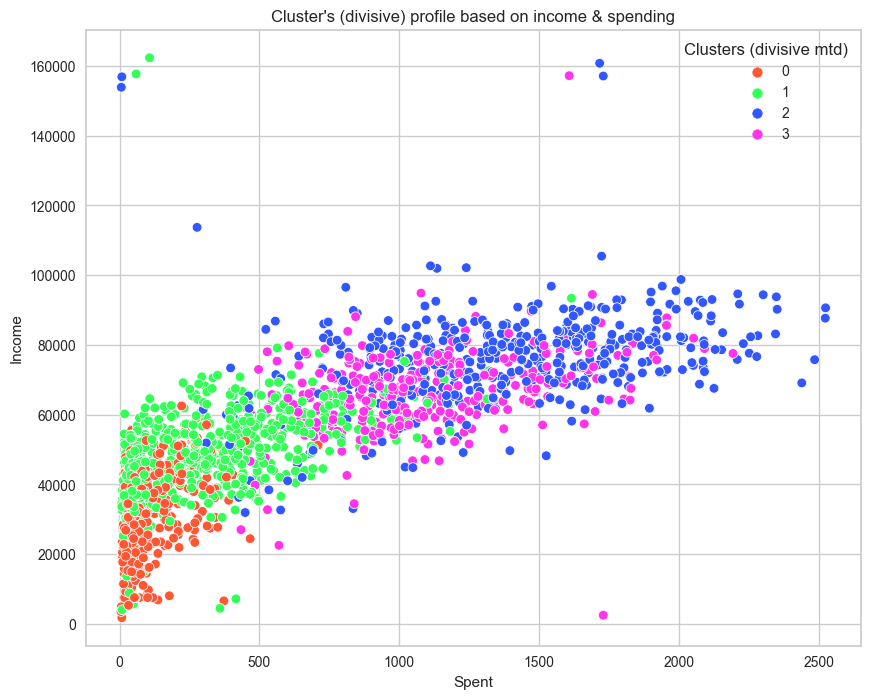

In [64]:
import seaborn as sns

palette = ["#FF5733", "#33FF57", "#3357FF", "#FF33EC"]
plt.figure(figsize=(10, 8))
scatterplot = sns.scatterplot(data=og_data_div, x="Spent", y="Income", hue="Cluster", palette=palette)
scatterplot.set_title("Cluster's (divisive) profile based on income & spending")
plt.legend(title="Clusters (divisive mtd)")
plt.show()

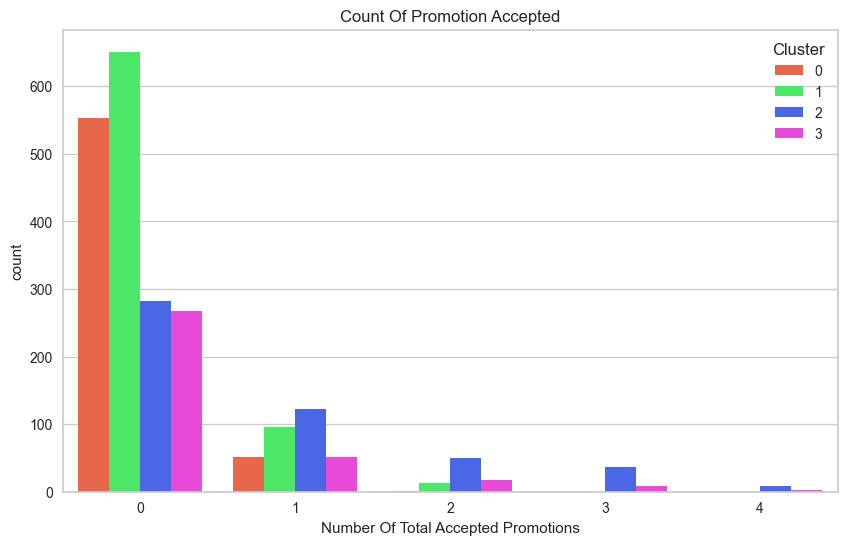

In [65]:
og_data_div["Total_Promos"] = og_data_div["AcceptedCmp1"] + og_data_div["AcceptedCmp2"] + og_data_div["AcceptedCmp3"] + og_data_div["AcceptedCmp4"] + og_data_div["AcceptedCmp5"]
plt.figure(figsize=(10, 6))
countplot = sns.countplot(x=og_data_div["Total_Promos"], hue=og_data_div["Cluster"], palette=palette)
countplot.set_title("Count Of Promotion Accepted")
countplot.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

## Num of clusters = 2

In [70]:
from sklearn.cluster import KMeans
def divisive_clustering(data, n_clusters):
    clusters = {0: data}  # Start with all data in one cluster
    cluster_labels = np.zeros(len(data))  # Label for each data point
    current_cluster_id = 1  # Used to label newly created clusters

    # Split clusters iteratively until we reach the desired number of clusters
    while len(clusters) < n_clusters:
        # Find the largest cluster to split
        largest_cluster_id = max(clusters, key=lambda k: len(clusters[k]))
        largest_cluster = clusters.pop(largest_cluster_id)  # Remove the cluster

        # Perform KMeans with k=2 on the largest cluster
        kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42).fit(largest_cluster)
        labels = kmeans.labels_

        # Split the cluster into two based on KMeans labels
        cluster_1 = largest_cluster[labels == 0]
        cluster_2 = largest_cluster[labels == 1]

        # Add the new clusters to the cluster dictionary
        clusters[current_cluster_id] = cluster_1
        clusters[current_cluster_id + 1] = cluster_2

        # Update the labels of the original dataset
        cluster_labels[np.isin(data, cluster_1).all(axis=1)] = current_cluster_id
        cluster_labels[np.isin(data, cluster_2).all(axis=1)] = current_cluster_id + 1

        current_cluster_id += 2

    return cluster_labels

n_clusters = 2
PCA_ds_div = PCA_ds.copy()
yhat_div = divisive_clustering(PCA_ds_div, n_clusters)

In [73]:
np.unique(yhat_div)

array([1., 2.])

In [74]:
PCA_ds_div['Cluster'] = yhat_div    

silhouette_div = silhouette_score(PCA_ds, PCA_ds_div['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.4f}")
    
db_index_div = davies_bouldin_score(PCA_ds, PCA_ds_div['Cluster'])
print(f"Davies-Bouldin Index: {db_index_div:.4f}")
    
ch_index_div = calinski_harabasz_score(PCA_ds, PCA_ds_div['Cluster'])
print(f"Calinski-Harabasz Index: {ch_index_div:.4f}")

Silhouette Score: 0.1370
Davies-Bouldin Index: 0.9068
Calinski-Harabasz Index: 2270.4756


# Clustering: DBSCAN

Can tune parameters: eps, min_samples

## Grid Search

In [65]:
from sklearn.cluster import DBSCAN

# Grid search mtd
def dbscan_with_params(data, eps_values, min_samples_values):
    best_eps = None
    best_min_samples = None
    best_silhouette = -1  # Start with lowest possible score
    best_labels = None

    results = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Fit DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            
            # Must have at least 2 clusters (ignore noise points, labeled as -1)
            if len(set(labels)) > 2 and not all(label == -1 for label in labels):  # Avoid cases where all are noise
                score = silhouette_score(data, labels)
                results.append((eps, min_samples, score))
                print(f"DBSCAN with eps={eps} and min_samples={min_samples} -> Silhouette Score: {score:.4f}")
                
                # Keep track of the best Silhouette Score
                if score > best_silhouette:
                    best_silhouette = score
                    best_eps = eps
                    best_min_samples = min_samples
                    best_labels = labels

    return best_eps, best_min_samples, best_silhouette, best_labels, results


# Parameter ranges for tuning
eps_values = np.arange(0.1, 1.1, 0.1)    # eps from 0.1 to 1.0 with step 0.1
min_samples_values = range(3, 10)      # min_samples from 3 to 9

PCA_ds_dbscan = PCA_ds.copy()
best_eps, best_min_samples, best_silhouette, best_labels, tuning_results = dbscan_with_params(PCA_ds_dbscan, eps_values, min_samples_values)
print(f"\nBest DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples} with Silhouette Score={best_silhouette:.4f}")

DBSCAN with eps=0.1 and min_samples=3 -> Silhouette Score: -0.6592
DBSCAN with eps=0.1 and min_samples=4 -> Silhouette Score: -0.2870
DBSCAN with eps=0.1 and min_samples=5 -> Silhouette Score: -0.2060
DBSCAN with eps=0.2 and min_samples=3 -> Silhouette Score: -0.4660
DBSCAN with eps=0.2 and min_samples=4 -> Silhouette Score: -0.5515
DBSCAN with eps=0.2 and min_samples=5 -> Silhouette Score: -0.4664
DBSCAN with eps=0.2 and min_samples=6 -> Silhouette Score: -0.4802
DBSCAN with eps=0.2 and min_samples=7 -> Silhouette Score: -0.1804
DBSCAN with eps=0.2 and min_samples=8 -> Silhouette Score: -0.1541
DBSCAN with eps=0.2 and min_samples=9 -> Silhouette Score: -0.1554
DBSCAN with eps=0.30000000000000004 and min_samples=3 -> Silhouette Score: -0.2328
DBSCAN with eps=0.30000000000000004 and min_samples=4 -> Silhouette Score: -0.3207
DBSCAN with eps=0.30000000000000004 and min_samples=5 -> Silhouette Score: -0.3810
DBSCAN with eps=0.30000000000000004 and min_samples=6 -> Silhouette Score: -0.416

In [66]:
# Further Evaluation
db_index_dbscan = davies_bouldin_score(PCA_ds, best_labels)
print(f"Davies-Bouldin Index: {db_index_dbscan:.4f}")

ch_index_dbscan = calinski_harabasz_score(PCA_ds, best_labels)
print(f"Calinski-Harabasz Index: {ch_index_dbscan:.4f}")

Davies-Bouldin Index: 3.2834
Calinski-Harabasz Index: 8.7237


## K-dist graph

Lec mtd: Choose eps given minPts -> Use K-distance graph
1. Step 1: Calculate the average distance between each point in the data set and its K nearest neighbors (set K as the MinPts value).
2. Step 2: Sort distance values by ascending value and plot the K-distance graph
3. Step 3: find the elbow point in the graph and use the corresponding distance as Epsilon

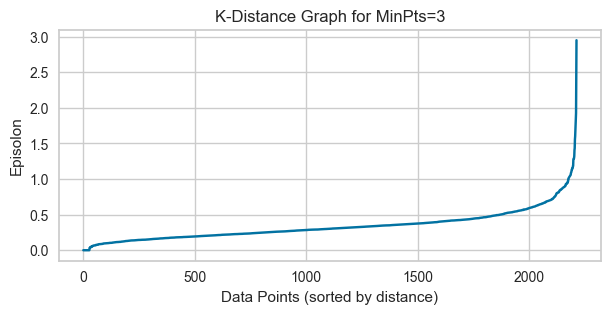

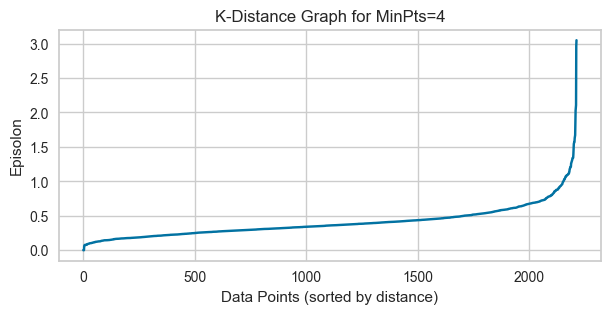

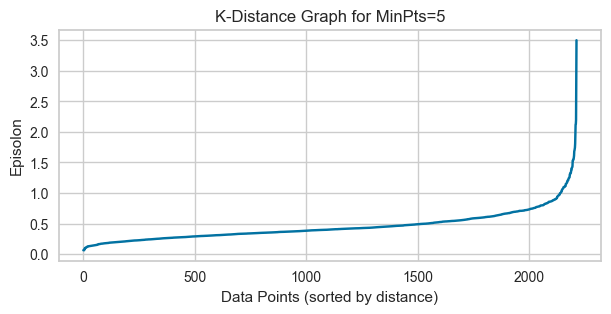

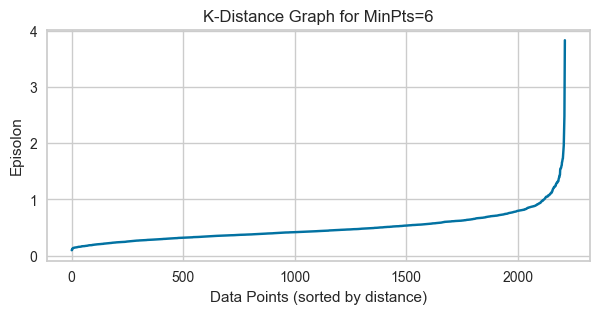

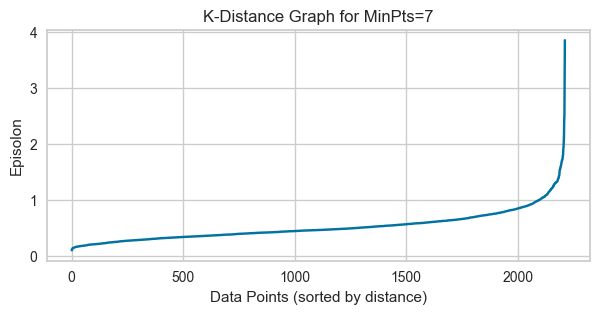

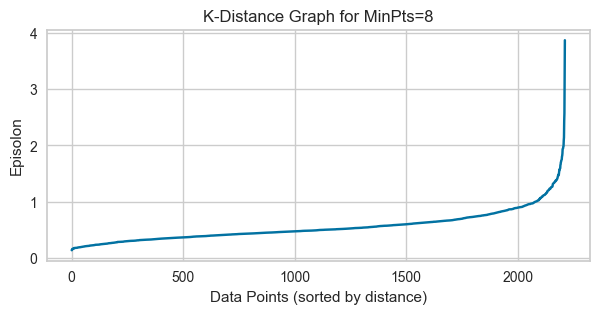

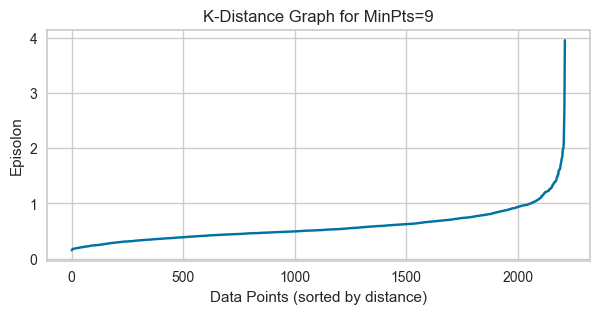

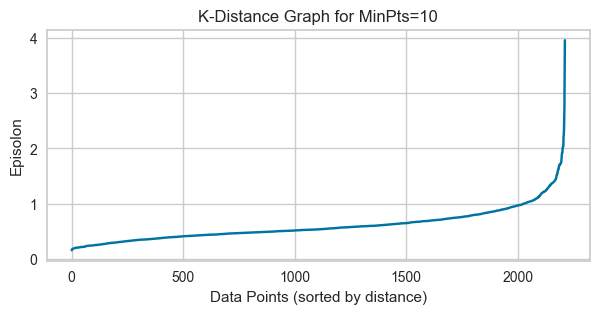

In [70]:
from sklearn.neighbors import NearestNeighbors

def plot_k_distance_graph(PCA_ds, minPts_values):
    for minPts in minPts_values:
        # Step 1: Calculate avg dist btw each point and its K nearest neighbors
        neighbors = NearestNeighbors(n_neighbors=minPts)
        neighbors_fit = neighbors.fit(PCA_ds)
        distances, indices = neighbors_fit.kneighbors(PCA_ds)
    
        # Step 2: Sort distance values in ascending order
        distances = np.sort(distances[:, minPts - 1])  
    
        # Step 3: Plot the K-distance graph
        plt.figure(figsize=(7,3))
        plt.plot(distances, label=f'minPts={minPts}')
        plt.xlabel('Data Points (sorted by distance)')
        plt.ylabel('Episolon')
        plt.title(f'K-Distance Graph for MinPts={minPts}')
        plt.grid(True)
        plt.show()

minPts_values = range(3, 11)
plot_k_distance_graph(PCA_ds, minPts_values)

In [71]:
minpt_eps_pairs = [(3,0.7), (4,0.8), (5,1), (6,1.1), (7,1.2), (8,1.3), (9,1.3), (10,1.4)]
results = {}

for pairs in minpt_eps_pairs:   
    dbscan = DBSCAN(eps=pairs[1], min_samples=pairs[0])
    labels = dbscan.fit_predict(PCA_ds)

    # Evaluation scores
    silhouette_avg = silhouette_score(PCA_ds, labels)
    db_index = davies_bouldin_score(PCA_ds, labels)
    ch_index = calinski_harabasz_score(PCA_ds, labels)
    
    # Store results
    results[pairs] = {
        "Silhouette Score": silhouette_avg,
        "Davies-Bouldin Index": db_index,
        "Calinski-Harabasz Index": ch_index
    }

print("Comparison of different eps & minPt pairs:")
for pairs, metrics in results.items():
    print(f"\nEps-MinPt pair: {pairs}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

Comparison of different eps & minPt pairs:

Eps-MinPt pair: (3, 0.7)
Silhouette Score: -0.2172
Davies-Bouldin Index: 2.0806
Calinski-Harabasz Index: 8.6484

Eps-MinPt pair: (4, 0.8)
Silhouette Score: 0.0529
Davies-Bouldin Index: 2.9004
Calinski-Harabasz Index: 17.9393

Eps-MinPt pair: (5, 1)
Silhouette Score: 0.2724
Davies-Bouldin Index: 4.7524
Calinski-Harabasz Index: 7.8825

Eps-MinPt pair: (6, 1.1)
Silhouette Score: 0.2908
Davies-Bouldin Index: 3.4487
Calinski-Harabasz Index: 10.8425

Eps-MinPt pair: (7, 1.2)
Silhouette Score: 0.3022
Davies-Bouldin Index: 3.3180
Calinski-Harabasz Index: 9.8943

Eps-MinPt pair: (8, 1.3)
Silhouette Score: 0.3041
Davies-Bouldin Index: 3.0224
Calinski-Harabasz Index: 11.1811

Eps-MinPt pair: (9, 1.3)
Silhouette Score: 0.3041
Davies-Bouldin Index: 3.0224
Calinski-Harabasz Index: 11.1811

Eps-MinPt pair: (10, 1.4)
Silhouette Score: 0.3189
Davies-Bouldin Index: 3.1065
Calinski-Harabasz Index: 9.4032


In [79]:
dbscan = DBSCAN(eps=0.8, min_samples=4)
labels = dbscan.fit_predict(PCA_ds)

PCA_ds_dbscan = PCA_ds.copy()
PCA_ds_dbscan["Cluster"] = labels
og_data_dbscan = data.copy()
og_data_dbscan["Cluster"] = labels

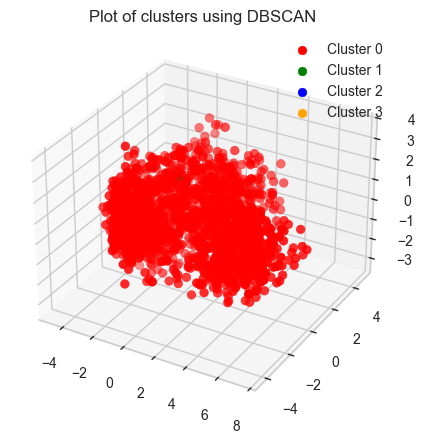

In [80]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d', label="bla")

for cluster_id in range(len(colors)):
    cluster_data = PCA_ds_dbscan[PCA_ds_dbscan["Cluster"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        cluster_data["col3"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

ax.set_title("Plot of clusters using DBSCAN")
ax.legend()
plt.show()

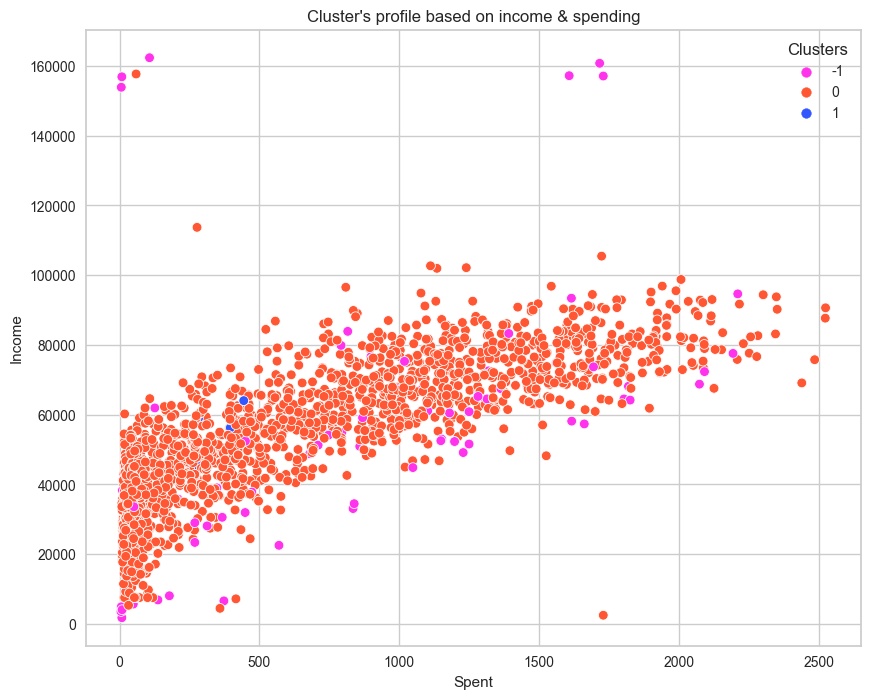

In [82]:
palette = ["#FF33EC", "#FF5733", "#3357FF"]
plt.figure(figsize=(10, 8))
scatterplot = sns.scatterplot(data=og_data_dbscan, x="Spent", y="Income", hue="Cluster", palette=palette)
scatterplot.set_title("Cluster's profile based on income & spending")
plt.legend(title="Clusters")
plt.show()

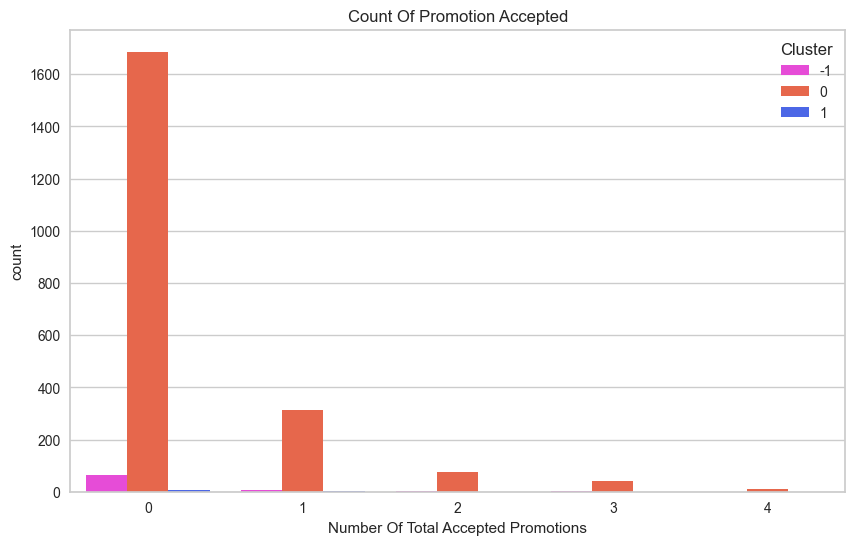

In [84]:
og_data_dbscan["Total_Promos"] = og_data_dbscan["AcceptedCmp1"] + og_data_dbscan["AcceptedCmp2"] + og_data_dbscan["AcceptedCmp3"] + og_data_dbscan["AcceptedCmp4"] + og_data_dbscan["AcceptedCmp5"]
plt.figure(figsize=(10, 6))
countplot = sns.countplot(x=og_data_dbscan["Total_Promos"], hue=og_data_dbscan["Cluster"], palette=palette)
countplot.set_title("Count Of Promotion Accepted")
countplot.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

In [85]:
dbscan = DBSCAN(eps=1.3, min_samples=8)
labels = dbscan.fit_predict(PCA_ds)

PCA_ds_dbscan = PCA_ds.copy()
PCA_ds_dbscan["Cluster"] = labels
og_data_dbscan = data.copy()
og_data_dbscan["Cluster"] = labels

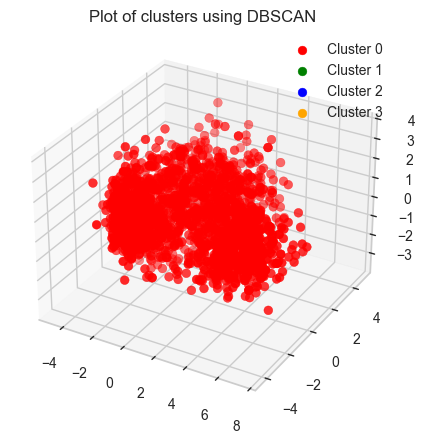

In [86]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d', label="bla")

for cluster_id in range(len(colors)):
    cluster_data = PCA_ds_dbscan[PCA_ds_dbscan["Cluster"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        cluster_data["col3"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

ax.set_title("Plot of clusters using DBSCAN")
ax.legend()
plt.show()

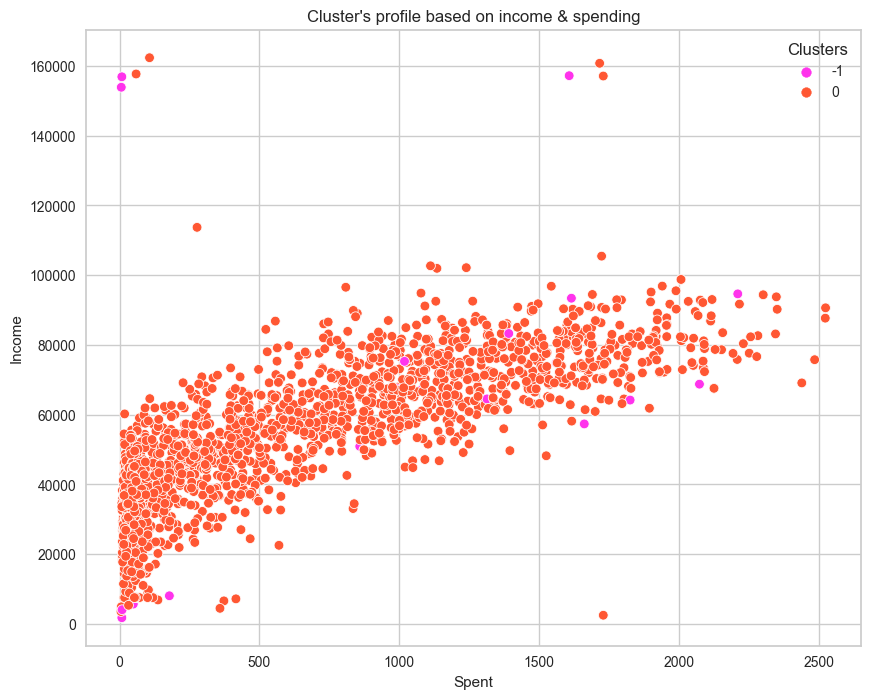

In [88]:
palette = ["#FF33EC", "#FF5733"]
plt.figure(figsize=(10, 8))
scatterplot = sns.scatterplot(data=og_data_dbscan, x="Spent", y="Income", hue="Cluster", palette=palette)
scatterplot.set_title("Cluster's profile based on income & spending")
plt.legend(title="Clusters")
plt.show()

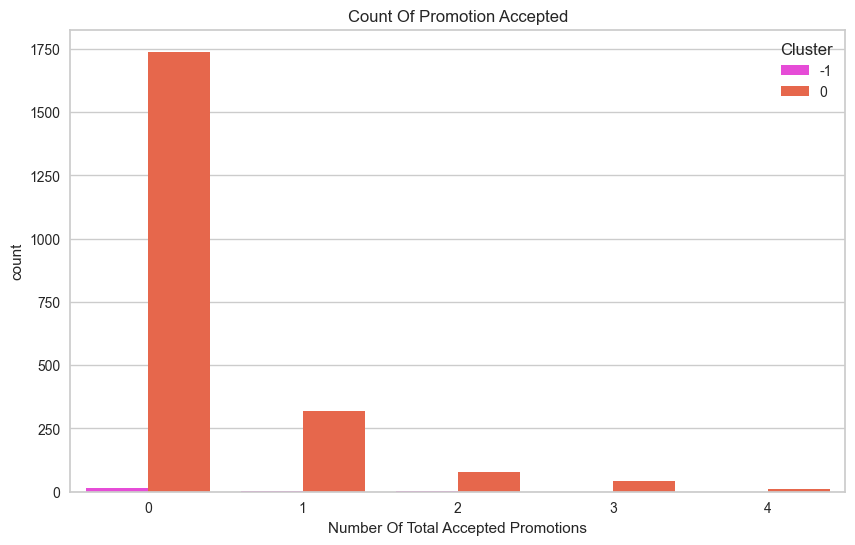

In [89]:
og_data_dbscan["Total_Promos"] = og_data_dbscan["AcceptedCmp1"] + og_data_dbscan["AcceptedCmp2"] + og_data_dbscan["AcceptedCmp3"] + og_data_dbscan["AcceptedCmp4"] + og_data_dbscan["AcceptedCmp5"]
plt.figure(figsize=(10, 6))
countplot = sns.countplot(x=og_data_dbscan["Total_Promos"], hue=og_data_dbscan["Cluster"], palette=palette)
countplot.set_title("Count Of Promotion Accepted")
countplot.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

## Overall

Overall DBscan seems like a bad mtd for this dataset -> possible reasons: clusters have varying density, hard to determine the eps and minpts. This dataset shouldnt have arbitrary shapes.

Another way to evaluate can be to profile customers and see how easy it is to do that / identify common attributes within the cluster based on the original data (non scaled, non PCA), cos if hard to profile, then the clusters wont be meaningful / wont help in achieving the goal.